In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


https://www.sfu.ca/~ssurjano/egg.html


f(x,y) = -(y + 47) * sin(sqrt(abs(y + x/2 + 47))) - x * sin(sqrt(abs(x - (y + 47))))


The Eggholder function is a difficult function to optimize, because of the large number of local minima. 

Input Domain: xi ∈ [-512, 512], for all i = 1, 2. 

Global minimum: (x, y) = (512, 404.2319), and its corresponding function value f(x,y) = -959.6407.

It's worth noting that the Eggholder function has a symmetric property, meaning that the global minimum can also be found at (-512, 404.2319), (512, -404.2319), or (-512, -404.2319), with the same function value of -959.6407.

For simplicity for MCMC group, we decided to shift the whole function up by 1000 to avoid negative values.

In [2]:
class EggholderLikelihood:
    '''
    This class represents the likelihood function based on the Eggholder function
    
    '''
    def __init__(self):
        '''
        Initialize the class with bounds for the x and y variables
        '''
        # Bounds for x and y variables
        self.bounds = [(-512, 512), (-512, 512)]  # The function is usually evaluated on the square xi ∈ [-512, 512], for all i = 1, 2

    def eggholder(self, x, y):
        '''
        Evaluates the Eggholder function at the given (x, y) coordinates

        Arguments
        x [float]: The x coordinate
        y [float]: The y coordinate

        Returns
        fxy [float]: The value of the Egg Holder function at (x, y)
        '''
        fxy = -(y + 47) * np.sin(np.sqrt(abs(x/2 + (y + 47)))) - x * np.sin(np.sqrt(abs(x - (y + 47))))+1000
        return fxy
    
    def evaluate(self, params):
        '''
        Evaluates the Eggholder function at the given (x, y) coordinates

        Arguments
        params [tuple]: The parameter values (x, y) for the Eggholder function

        Returns
        fxy [float]: The value of the Egg Holder function at (x, y)
        '''
        x, y = params
        fxy = self.eggholder(x, y)
        return fxy


    def log_likelihood(self, params, z_observed):
        '''
        Calculates the log likelihood value based on the observed and predicted values

        Arguments
        params [tuple]: The parameter values (x, y) for the Eggholder function
        z_observed [array]: The observed values of the Eggholder function

        Returns
        log_likelihood [float]: The log-likelihood value
        '''
        x, y = params
        z_predicted = self.evaluate(params)
        log_likelihood = -0.5 * np.sum((z_observed - z_predicted) ** 2)
        return log_likelihood

    def log_prior(self, params):
        '''
        Calculates the log prior probability based on the parameter values

        Arguments
        params [tuple]: The parameter values (x, y) for the Eggholder function

        Returns
        log_prior [float]: The log-prior probability
        '''
        x, y = params
        if self.bounds[0][0] <= x <= self.bounds[0][1] and self.bounds[1][0] <= y <= self.bounds[1][1]:
            return 0.0
        else:
            return -np.inf

    def log_posterior(self, params, z_observed):
        '''
        Calculates the log posterior probability based on the parameter values and observed values

        Arguments
        params [tuple]: The parameter values (x, y) for the Eggholder function
        z_observed [array-like]: The observed values of the Eggholder function

        Returns:
        log_posterior [float]: The log-posterior probability
        '''
        log_prior = self.log_prior(params)
        if np.isinf(log_prior):
            return log_prior
        log_likelihood = self.log_likelihood(params, z_observed)
        return log_prior + log_likelihood
    
    def add_poisson_fluctuation(self, z):
        '''
        Adds Poisson fluctuation to the Eggolder function values

        Arguments
        z [array]: The values of the Eggholder function

        Returns
        z_fluctuated [array]: The fluctuated values of the Eggholder function
        '''
        offset = np.abs(np.min(z))
        z_offset = z + offset
        z_fluctuated = np.random.poisson(z_offset)
        z_fluctuated -= np.array(offset, dtype=z_fluctuated.dtype)
        return z_fluctuated

    def plot_scatter(self):
        '''
        Creates a 3D scatter plot of the Eggholder function with Poisson fluctuation
        '''
        
        # Create an array of x and y values
        x = np.linspace(-512, 512, 400)
        y = np.linspace(-512, 512, 400)

        # Create a grid of x and y values
        x, y = np.meshgrid(x, y)

        # Calculate the z values
        z = self.eggholder(x, y)

        # Add Poisson fluctuation to z values
        z_fluctuated = self.add_poisson_fluctuation(z)

        # Create the plot
        fig = plt.figure(figsize=(15, 10))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(x, y, z_fluctuated, cmap='viridis', edgecolor='k')
        ax.set_title('3D Plot of Eggholder Function with Poisson Fluctuation')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('f(x, y)')
        plt.savefig('3D Eggholder Function with Poisson Fluctuation')
        plt.show()
        
    def find_peaks(self, num_points=100):
        '''
        Finds the number of peaks in the Eggholder function

        Arguments
        num_points [int]: The number of points to evaluate the function

        Returns
        peaks [int]: The number of peaks in the function
        peak_coordinates [list]: The coordinates of the peaks in the function
        '''
        x = np.linspace(-512, 512, num_points)
        y = np.linspace(-512, 512, num_points)
        X, Y = np.meshgrid(x, y)
        z = self.eggholder(X, Y)

        peaks = 0
        peak_coordinates = []
        for i in range(1, num_points - 1):
            for j in range(1, num_points - 1):
                if (
                z[i, j] > z[i-1, j] and z[i, j] > z[i+1, j] and
                z[i, j] > z[i, j-1] and z[i, j] > z[i, j+1]
            ):
                    peaks += 1
        return peaks, peak_coordinates

    def find_troughs(self, num_points=100):
        '''
        Finds the number of troughs in the Eggholder function

        Arguments
        num_points [int]: The number of points to evaluate the function

        Returns
        troughs [int]: The number of troughs in the function
        trough_coordinates [list]: The coordinates of the troughs in the function
        '''
        x = np.linspace(-512, 512, num_points)
        y = np.linspace(-512, 512, num_points)
        X, Y = np.meshgrid(x, y)
        z = self.eggholder(X, Y)

        troughs = 0
        trough_coordinates = []

        for i in range(1, num_points - 1):
            for j in range(1, num_points - 1):
                if (
                    z[i, j] < z[i-1, j] and z[i, j] < z[i+1, j] and
                    z[i, j] < z[i, j-1] and z[i, j] < z[i, j+1]
                ):
                    troughs += 1
                    trough_coordinates.append((X[i, j], Y[i, j]))

        return troughs, trough_coordinates

    
    def find_local_minimum(self, start_point, learning_rate=0.01, num_iterations=100):
        '''
        Finds a local minimum of the Eggholder function starting from the given start_point

        Arguments
        start_point [tuple]: The starting point (x, y) for the optimization
        learning_rate [float]: The learning rate for gradient descent
        num_iterations [int]: The number of iterations for gradient descent

        Returns
        current_point [tuple]: The coordinates (x, y) of the local minimum
        history [list]: The history of points visited during the optimization process
        '''

        current_point = np.array(start_point)
        history = [current_point]

        for _ in range(num_iterations):
            x, y = current_point
            grad_x = -(y + 47) * np.sin(np.sqrt(abs(x/2 + (y + 47)))) - x * np.sin(np.sqrt(abs(x - (y + 47)))) * (1/2) * (1/np.sqrt(abs(x - (y + 47)))) * np.sign(x - (y + 47))
            grad_y = -(y + 47) * np.sin(np.sqrt(abs(x/2 + (y + 47)))) - (1/2) * np.sin(np.sqrt(abs(x - (y + 47)))) * (1/np.sqrt(abs(x/2 + (y + 47)))) * np.sign(y + 47) - x * np.sin(np.sqrt(abs(x - (y + 47))))
            gradient = np.array([grad_x, grad_y])
            current_point = current_point - learning_rate * gradient
            history.append(current_point)

        return current_point, history



In [3]:
# Instantiate the EggholderLikelihood class
eggholder = EggholderLikelihood()

# Choose parameter values for testing
params = (100, -200)  # Example parameter values

# Calculate the likelihood
likelihood_value = eggholder.evaluate(params)
print("Likelihood:", likelihood_value)

# Generate random observed z values
np.random.seed(42)  # Set random seed for reproducibility
z_observed = np.random.uniform(-100, 100, size=(10, 10))

# Calculate the log-likelihood
log_likelihood_value = eggholder.log_likelihood(params, z_observed)
print("Log-Likelihood:", log_likelihood_value)

# Calculate the prior
prior_value = eggholder.log_prior(params)
print("Prior:", prior_value)

# Calculate the posterior
posterior_value = eggholder.log_posterior(params, z_observed)
print("Posterior:", posterior_value)



Likelihood: 918.3137325163473
Log-Likelihood: -42889682.49985977
Prior: 0.0
Posterior: -42889682.49985977


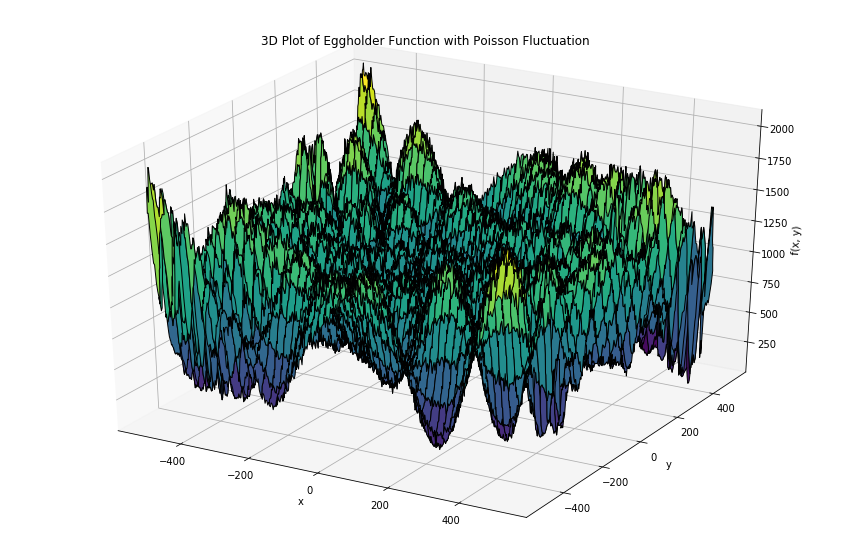

In [4]:
# Plot the scatter plot
eggholder.plot_scatter()

In [5]:
# Find the number of troughs
num_troughs, trough_coordinates = eggholder.find_troughs()
print("Number of troughs:", num_troughs)


print("Trough coordinates and their likelihood values:")
for coordinate in trough_coordinates:
    likelihood_value = eggholder.evaluate(coordinate)
    print("(x,y) =", coordinate, ", f(x,y) =", likelihood_value)



Number of troughs: 213
Trough coordinates and their likelihood values:
(x,y) = (-480.969696969697, -501.65656565656565) , f(x,y) = 989.2245268367944
(x,y) = (-429.25252525252523, -501.65656565656565) , f(x,y) = 899.427790306034
(x,y) = (-470.62626262626264, -491.3131313131313) , f(x,y) = 927.7439898860323
(x,y) = (-418.9090909090909, -491.3131313131313) , f(x,y) = 791.1010632282287
(x,y) = (284.44444444444446, -491.3131313131313) , f(x,y) = 285.5901597361344
(x,y) = (-460.2828282828283, -480.969696969697) , f(x,y) = 837.5379151557486
(x,y) = (-408.5656565656566, -480.969696969697) , f(x,y) = 669.8489418052517
(x,y) = (-449.93939393939394, -470.62626262626264) , f(x,y) = 727.8588026511231
(x,y) = (-398.22222222222223, -470.62626262626264) , f(x,y) = 547.9663313955839
(x,y) = (-305.1313131313131, -470.62626262626264) , f(x,y) = 313.8087660766305
(x,y) = (-439.5959595959596, -460.2828282828283) , f(x,y) = 609.8346788488419
(x,y) = (-387.8787878787879, -460.2828282828283) , f(x,y) = 437.96

In [6]:
# Find the global minimum

min_likelihood = float('inf')  # Initialize with a large value
min_coordinate = None

for coordinate in trough_coordinates:
    likelihood_value = eggholder.evaluate(coordinate)
    if likelihood_value < min_likelihood:
        min_likelihood = likelihood_value
        min_coordinate = coordinate

print("Global minimum:")
print("(x,y):", min_coordinate)
print("f(x,y):", min_likelihood)


Global minimum:
(x,y): (439.5959595959597, 449.939393939394)
f(x,y): 81.92200365776057
